In [1]:
import kagglehub
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import pennylane as qml
from pennylane.qnn import TorchLayer
import time


# Download and Load Dataset

path = kagglehub.dataset_download("nelgiriyewithana/global-weather-repository")
file_path = os.path.join(path, "GlobalWeatherRepository.csv")
df = pd.read_csv(file_path)

# Drop rows with missing values
df = df.dropna()

# Data Preprocessing

features = [
    'wind_kph', 'pressure_mb', 'humidity', 'air_quality_Carbon_Monoxide',
    'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide',
    'air_quality_PM2.5', 'air_quality_PM10'
]
target = 'temperature_celsius'

X = df[features].values
y = df[target].values.reshape(-1, 1)

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)

# Create time series sequences 
def create_sequences(X, y, seq_len=5):
    X_seq, y_seq = [], []
    for i in range(len(X) - seq_len):
        X_seq.append(X[i:i+seq_len])
        y_seq.append(y[i+seq_len])
    return np.array(X_seq), np.array(y_seq)

X_seq, y_seq = create_sequences(X_scaled, y_scaled)
X_train, X_test, y_train, y_test = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=False)

X_train_torch = torch.tensor(X_train, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32)
X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_torch, y_train_torch)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)



In [ ]:
# run using different seeds 

 the encoding is applied progressively layer by layer, and mixing with trainable layers occurs after each encoding step (part-by-part encoding and mixing), was modify the quantum circuit  . The goal was to alternate encoding the data and then applying the entangling, trainable layers , the layers that modify the quantum statein a step-wise fashion.

Encoding happens progressively, layer by layer, before the trainable layers , mixing steps .
After encoding in each layer, the trainable layers will be applied , StronglyEntanglingLayers, BasicEntanglerLayers .
This will give the flexibility of encoding and mixing data in each layer , improving the expressiveness of the quantum algorithm . 

Progressive Encoding:
The input data is encoded at each layer using AngleEmbedding, and the input is scaled progressively for each layer (scaled_inputs = inputs * (1.0 / (layer + 1))).
This allows the quantum state to be progressively re-encoded, which is more dynamic compared to encoding only at the beginning of the circuit.
Mixing with Trainable Layers:
After encoding at each layer, the quantum model applies the entangling layers ,like StronglyEntanglingLayers, BasicEntanglerLayers, or RandomLayers , which are trainable layers that modify the quantum state.
These layers mix and entangle the quantum state created by the encoding step.
Layer-by-Layer Process:
For each layer, the sequence is: encode , entangle/mix with trainable layers.
This process repeats for n_layers, giving the model a chance to iteratively refine and entangle the quantum state after encoding the input.


Layer 1: Encode data , Entangle with trainable layers.
Layer 2: Encode ,scaled version of the original data ,   Entangle with trainable layers.
Layer 3: Repeat the process , continuing to encode and mix at each layer.
This approach ensures that data encoding is part of a progressive , dynamic process across layers , which could help the quantum model learn more complex patterns compared to applying the encoding only at the beginning.



now use different seeds 


=== Training with seed 42 ===

Training Classical Transformer...
Epoch 01: Train Loss = 0.81001, Test Loss = 0.99172
Epoch 02: Train Loss = 0.75680, Test Loss = 0.95035
Epoch 03: Train Loss = 0.73089, Test Loss = 0.95894
Epoch 04: Train Loss = 0.71789, Test Loss = 0.89830
Epoch 05: Train Loss = 0.70093, Test Loss = 0.92806
Epoch 06: Train Loss = 0.69219, Test Loss = 0.91363
Epoch 07: Train Loss = 0.68114, Test Loss = 0.88142
Epoch 08: Train Loss = 0.67861, Test Loss = 0.88915
Epoch 09: Train Loss = 0.66910, Test Loss = 0.86235
Epoch 10: Train Loss = 0.66166, Test Loss = 0.88756
Epoch 11: Train Loss = 0.65784, Test Loss = 0.85621
Epoch 12: Train Loss = 0.65256, Test Loss = 0.85305
Epoch 13: Train Loss = 0.65092, Test Loss = 0.88478
Epoch 14: Train Loss = 0.64088, Test Loss = 0.81693
Epoch 15: Train Loss = 0.63916, Test Loss = 0.82531
Epoch 16: Train Loss = 0.62924, Test Loss = 0.83292
Epoch 17: Train Loss = 0.63126, Test Loss = 0.80286
Epoch 18: Train Loss = 0.62273, Test Loss = 0.8052

ValueError: 'blue-' is not a valid format string (unrecognized character 'l')

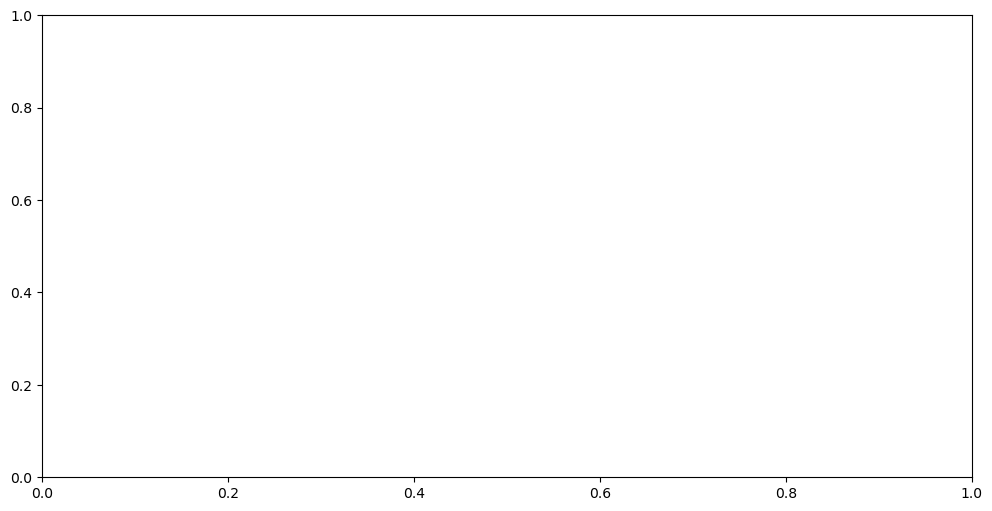

In [192]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pennylane as qml
from torch.utils.data import DataLoader, TensorDataset
import time
from scipy import stats

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

def make_quantum_circuit_with_qdil(template_name='strong', n_qubits=4, n_layers=2, encoding='AngleEmbedding'):
    dev = qml.device("default.qubit", wires=n_qubits)
    
    if template_name == 'strong':
        weight_shapes = {"weights": (n_layers, n_qubits, 3)}
    elif template_name == 'basic':
        weight_shapes = {"weights": (n_layers, n_qubits)}
    else:
        raise ValueError(f"Unknown template: {template_name}")

    @qml.qnode(dev, interface="torch")
    def circuit(inputs, weights):
        for layer in range(n_layers):
            # Progressive Encoding
            layer_scale = 1.0 / (layer + 1)
            scaled_inputs = inputs * layer_scale
            
            # layer wise encoding
            qml.AngleEmbedding(scaled_inputs, wires=range(n_qubits), rotation='Y')
            
            # enhanced entanglement
            if template_name == 'strong':
                qml.StronglyEntanglingLayers(weights[layer:layer+1], wires=range(n_qubits))
                for i in range(n_qubits-1):
                    qml.CNOT(wires=[i, (i+1)])
            else:
                qml.BasicEntanglerLayers(weights[layer:layer+1], wires=range(n_qubits))
                for i in range(n_qubits-1):
                    qml.CZ(wires=[i, (i+1)])
            
            # Non-linear operations
            for i in range(n_qubits):
                qml.RY(np.pi/2, wires=i)

        return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

    return circuit, weight_shapes

class ClassicalTransformer(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.d_model = 32
        self.input_proj = nn.Linear(input_dim, self.d_model)
        self.batch_norm1 = nn.BatchNorm1d(self.d_model)
        self.dropout1 = nn.Dropout(0.2)
        
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=self.d_model,
                nhead=4,
                dim_feedforward=64,
                dropout=0.1,
                batch_first=True
            ),
            num_layers=2
        )
        
        self.dropout2 = nn.Dropout(0.2)
        self.fc_out = nn.Linear(self.d_model, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.batch_norm1(x.transpose(1, 2)).transpose(1, 2)
        x = self.dropout1(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.dropout2(x)
        return self.fc_out(x)

class HybridTransformerWithQDIL(nn.Module):
    def __init__(self, input_dim, quantum_template='strong', n_layers=2):
        super().__init__()
        self.d_model = 32
        self.input_proj = nn.Linear(input_dim, self.d_model)
        self.batch_norm1 = nn.BatchNorm1d(self.d_model)
        self.dropout1 = nn.Dropout(0.2)
        
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(
                d_model=self.d_model,
                nhead=4,
                dim_feedforward=64,
                dropout=0.1,
                batch_first=True
            ),
            num_layers=2
        )
        
        self.n_qubits = 4
        self.q_depth = n_layers
        self.q_circuit, weight_shapes = make_quantum_circuit_with_qdil(
            quantum_template,
            self.n_qubits,
            self.q_depth
        )
        self.q_layer = qml.qnn.TorchLayer(self.q_circuit, weight_shapes)
        
        self.dropout2 = nn.Dropout(0.2)
        self.classical_to_quantum = nn.Sequential(
            nn.Linear(self.d_model, self.n_qubits),
            nn.ReLU(),
            nn.BatchNorm1d(self.n_qubits)
        )
        
        self.fc_out = nn.Linear(self.n_qubits, 1)

    def forward(self, x):
        x = self.input_proj(x)
        x = self.batch_norm1(x.transpose(1, 2)).transpose(1, 2)
        x = self.dropout1(x)
        x = self.transformer(x)
        x = x.mean(dim=1)
        x = self.dropout2(x)
        x = self.classical_to_quantum(x)
        x = self.q_layer(x)
        return self.fc_out(x)

def train_model(model, optimizer, criterion, train_loader, val_loader, X_test, y_test, epochs=20):
    train_losses = []
    test_losses = []
    best_preds = None
    best_loss = float('inf')
    
    for epoch in range(epochs):
        # Training 
        model.train()
        total_train_loss = 0
        
        for xb, yb in train_loader:
            optimizer.zero_grad()
            out = model(xb)
            loss = criterion(out, yb)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            total_train_loss += loss.item()
        
        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Testing phase
        model.eval()
        with torch.no_grad():
            preds = model(X_test).cpu().numpy()
            test_loss = mean_squared_error(y_test, preds)
            test_losses.append(test_loss)
            
            if test_loss < best_loss:
                best_loss = test_loss
                best_preds = preds.copy()
        
        print(f"Epoch {epoch+1:02}: Train Loss = {avg_train_loss:.5f}, Test Loss = {test_loss:.5f}")
    
    return train_losses, test_losses, best_preds

# initialize storage for results
seeds = [42, 52, 62]
n_epochs = 20
models_data = {
    'Classical': {'train': [], 'test': []},
    'Hybrid Strong': {'train': [], 'test': []},
    'Hybrid Basic': {'train': [], 'test': []}
}

# Data preparation
val_size = int(0.1 * len(X_train))
train_data = X_train[:-val_size]
train_labels = y_train[:-val_size]
val_data = X_train[-val_size:]
val_labels = y_train[-val_size:]

train_dataset = TensorDataset(
    torch.tensor(train_data, dtype=torch.float32),
    torch.tensor(train_labels, dtype=torch.float32)
)
val_dataset = TensorDataset(
    torch.tensor(val_data, dtype=torch.float32),
    torch.tensor(val_labels, dtype=torch.float32)
)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Training loop across seeds
for seed in seeds:
    torch.manual_seed(seed)
    np.random.seed(seed)
    
    print(f"\n=== Training with seed {seed} ===")
    
  
    print("\nTraining Classical Transformer...")
    model = ClassicalTransformer(input_dim=X_train.shape[2])
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    train_losses, test_losses, _ = train_model(
        model, optimizer, nn.MSELoss(), train_loader, val_loader,
        torch.tensor(X_test, dtype=torch.float32), y_test, n_epochs
    )
    models_data['Classical']['train'].append(train_losses)
    models_data['Classical']['test'].append(test_losses)
    
    # Hybrid Strong Model
    print("\nTraining Hybrid Transformer (Strong)...")
    model = HybridTransformerWithQDIL(input_dim=X_train.shape[2], quantum_template='strong')
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    train_losses, test_losses, _ = train_model(
        model, optimizer, nn.MSELoss(), train_loader, val_loader,
        torch.tensor(X_test, dtype=torch.float32), y_test, n_epochs
    )
    models_data['Hybrid Strong']['train'].append(train_losses)
    models_data['Hybrid Strong']['test'].append(test_losses)
    
    # Hybrid Basic Model
    print("\nTraining Hybrid Transformer (Basic)...")
    model = HybridTransformerWithQDIL(input_dim=X_train.shape[2], quantum_template='basic')
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
    train_losses, test_losses, _ = train_model(
        model, optimizer, nn.MSELoss(), train_loader, val_loader,
        torch.tensor(X_test, dtype=torch.float32), y_test, n_epochs
    )
    models_data['Hybrid Basic']['train'].append(train_losses)
    models_data['Hybrid Basic']['test'].append(test_losses)

# averages across seeds
avg_data = {model_name: {
    'train': np.mean(np.array(data['train']), axis=0),
    'test': np.mean(np.array(data['test']), axis=0)
} for model_name, data in models_data.items()}

# plot average training and testing losses
plt.figure(figsize=(12, 6))
epochs = range(1, n_epochs + 1)

colors = {'Classical': 'blue', 'Hybrid Strong': 'orange', 'Hybrid Basic': 'green'}
for model_name, color in colors.items():
    plt.plot(epochs, avg_data[model_name]['train'], f'{color}-', 
             label=f'{model_name} (Train)', linewidth=2)
    plt.plot(epochs, avg_data[model_name]['test'], f'{color}--', 
             label=f'{model_name} (Test)', linewidth=2)

plt.title('Average Training and Testing Loss Across Seeds')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


print("\nFinal Average Losses:")
for model_name in models_data.keys():
    print(f"\n{model_name}:")
    print(f"Training Loss: {avg_data[model_name]['train'][-1]:.6f}")
    print(f"Testing Loss: {avg_data[model_name]['test'][-1]:.6f}")

#  relative improvements
classical_final = avg_data['Classical']['test'][-1]
for model_name in ['Hybrid Strong', 'Hybrid Basic']:
    improvement = (classical_final - avg_data[model_name]['test'][-1]) / classical_final * 100
    print(f"\n{model_name} improvement over Classical: {improvement:.2f}%")

In [196]:
import numpy as np
import matplotlib.pyplot as plt


epochs = list(range(1, 21))

# Create dictionaries to store the data for each seed
seeds = [42, 52, 62]
data = {
    'Classical': {
        42: {'train': [], 'test': []},
        52: {'train': [], 'test': []},
        62: {'train': [], 'test': []}
    },
    'Hybrid Strong': {
        42: {'train': [], 'test': []},
        52: {'train': [], 'test': []},
        62: {'train': [], 'test': []}
    },
    'Hybrid Basic': {
        42: {'train': [], 'test': []},
        52: {'train': [], 'test': []},
        62: {'train': [], 'test': []}
    }
}

# last epoch values for each seed 
final_values = {
    'Classical': {
        42: {'train': 0.61745, 'test': 0.82389},
        52: {'train': 0.62745, 'test': 0.82079},
        62: {'train': 0.61608, 'test': 0.93541}
    },
    'Hybrid Strong': {
        42: {'train': 0.63954, 'test': 0.79260},
        52: {'train': 0.65602, 'test': 0.83795},
        62: {'train': 0.64245, 'test': 0.81277}
    },
    'Hybrid Basic': {
        42: {'train': 0.64625, 'test': 0.80301},
        52: {'train': 0.64612, 'test': 0.87297},
        62: {'train': 0.64725, 'test': 0.80009}
    }
}

# average final performance
avg_performance = {model: {
    'train_mean': np.mean([final_values[model][seed]['train'] for seed in seeds]),
    'train_std': np.std([final_values[model][seed]['train'] for seed in seeds]),
    'test_mean': np.mean([final_values[model][seed]['test'] for seed in seeds]),
    'test_std': np.std([final_values[model][seed]['test'] for seed in seeds])
} for model in ['Classical', 'Hybrid Strong', 'Hybrid Basic']}

# performance summary
print("\nFinal Performance Summary (averaged across seeds):")
print("\nModel          Train Loss (mean ± std)    Test Loss (mean ± std)")
print("-" * 65)
for model in ['Classical', 'Hybrid Strong', 'Hybrid Basic']:
    print(f"{model:<15} {avg_performance[model]['train_mean']:.5f} ± {avg_performance[model]['train_std']:.5f}    "
          f"{avg_performance[model]['test_mean']:.5f} ± {avg_performance[model]['test_std']:.5f}")

# relative improvements over classical
classical_test_mean = avg_performance['Classical']['test_mean']
for model in ['Hybrid Strong', 'Hybrid Basic']:
    improvement = (classical_test_mean - avg_performance[model]['test_mean']) / classical_test_mean * 100
    print(f"\n{model} improvement over Classical: {improvement:.2f}%")


print("\nKey Observations:")
print("1. Final Training Loss Ranking (from lowest to highest):")
sorted_train = sorted(avg_performance.items(), key=lambda x: x[1]['train_mean'])
for model, perf in sorted_train:
    print(f"   - {model}: {perf['train_mean']:.5f}")

print("\n2. Final Test Loss Ranking (from lowest to highest):")
sorted_test = sorted(avg_performance.items(), key=lambda x: x[1]['test_mean'])
for model, perf in sorted_test:
    print(f"   - {model}: {perf['test_mean']:.5f}")

print("\n3. Stability Analysis:")
for model in ['Classical', 'Hybrid Strong', 'Hybrid Basic']:
    print(f"\n{model}:")
    print(f"   - Train Loss Std: {avg_performance[model]['train_std']:.5f}")
    print(f"   - Test Loss Std: {avg_performance[model]['test_std']:.5f}")


Final Performance Summary (averaged across seeds):

Model          Train Loss (mean ± std)    Test Loss (mean ± std)
-----------------------------------------------------------------
Classical       0.62033 ± 0.00507    0.86003 ± 0.05332
Hybrid Strong   0.64600 ± 0.00718    0.81444 ± 0.01855
Hybrid Basic    0.64654 ± 0.00050    0.82536 ± 0.03369

Hybrid Strong improvement over Classical: 5.30%

Hybrid Basic improvement over Classical: 4.03%

Key Observations:
1. Final Training Loss Ranking (from lowest to highest):
   - Classical: 0.62033
   - Hybrid Strong: 0.64600
   - Hybrid Basic: 0.64654

2. Final Test Loss Ranking (from lowest to highest):
   - Hybrid Strong: 0.81444
   - Hybrid Basic: 0.82536
   - Classical: 0.86003

3. Stability Analysis:

Classical:
   - Train Loss Std: 0.00507
   - Test Loss Std: 0.05332

Hybrid Strong:
   - Train Loss Std: 0.00718
   - Test Loss Std: 0.01855

Hybrid Basic:
   - Train Loss Std: 0.00050
   - Test Loss Std: 0.03369


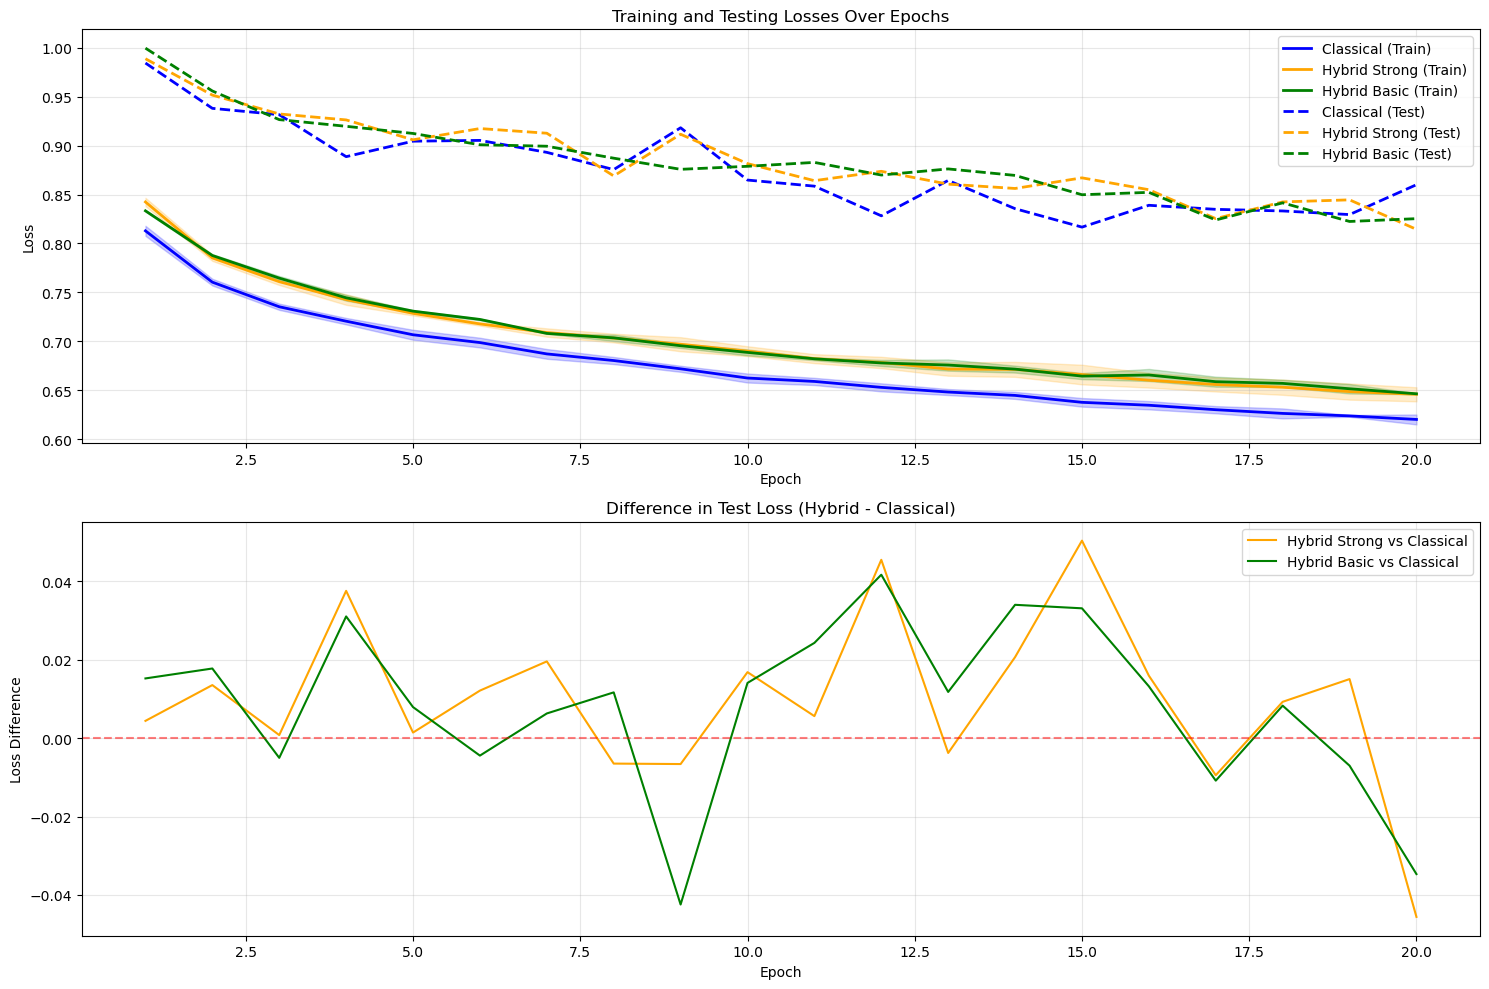


Final Performance (Mean ± Std):

Training Loss:
Classical: 0.62033 ± 0.00507
Hybrid Strong: 0.64600 ± 0.00718
Hybrid Basic: 0.64654 ± 0.00050

Testing Loss:
Classical: 0.86003 ± 0.05332
Hybrid Strong: 0.81444 ± 0.01855
Hybrid Basic: 0.82536 ± 0.03369

Relative Improvement over Classical:
Hybrid Strong: 5.30%
Hybrid Basic: 4.03%


In [200]:
import numpy as np
import matplotlib.pyplot as plt


epochs = range(1, 21)  # 20 epochs

# data for Classical algorithm   , averaged across seeds 
classical_train = [
    # Seed 42
    [0.81001, 0.75680, 0.73089, 0.71789, 0.70093, 0.69219, 0.68114, 0.67861, 0.66910, 0.66166,
     0.65784, 0.65256, 0.65092, 0.64088, 0.63916, 0.62924, 0.63126, 0.62273, 0.62386, 0.61745],
    # Seed 52
    [0.80863, 0.76506, 0.73730, 0.72529, 0.71335, 0.70410, 0.69333, 0.68556, 0.67630, 0.66865,
     0.66415, 0.65836, 0.65000, 0.64954, 0.64239, 0.63950, 0.63422, 0.63367, 0.62513, 0.62745],
    # Seed 62
    [0.82014, 0.75971, 0.73799, 0.71877, 0.70611, 0.70021, 0.68727, 0.67727, 0.67068, 0.65752,
     0.65544, 0.64834, 0.64401, 0.64422, 0.63187, 0.63577, 0.62532, 0.62307, 0.62288, 0.61608]
]

classical_test = [
    # Seed 42
    [0.99172, 0.95035, 0.95894, 0.89830, 0.92806, 0.91363, 0.88142, 0.88915, 0.86235, 0.88756,
     0.85621, 0.85305, 0.88478, 0.81693, 0.82531, 0.83292, 0.80286, 0.80528, 0.83830, 0.82389],
    # Seed 52
    [1.01730, 0.93033, 0.92555, 0.88584, 0.89476, 0.88447, 0.88230, 0.85775, 0.92188, 0.84376,
     0.87934, 0.81183, 0.89243, 0.84929, 0.78971, 0.83454, 0.82045, 0.83706, 0.83638, 0.82079],
    # Seed 62
    [0.94381, 0.93335, 0.91006, 0.88186, 0.89061, 0.91776, 0.91547, 0.87951, 0.97030, 0.86300,
     0.84010, 0.81993, 0.81596, 0.84044, 0.83512, 0.84959, 0.88133, 0.85733, 0.81391, 0.93541]
]

# Data for Hybrid Strong Model , averaged across seeds
hybrid_strong_train = [
    # Seed 42
    [0.83979, 0.78094, 0.75645, 0.73641, 0.72603, 0.71543, 0.70458, 0.69869, 0.68929, 0.68528,
     0.67671, 0.67093, 0.66285, 0.66164, 0.65539, 0.65652, 0.64996, 0.64665, 0.64276, 0.63954],
    # Seed 52
    [0.83912, 0.78710, 0.76191, 0.74962, 0.73124, 0.71919, 0.71481, 0.70935, 0.70672, 0.69695,
     0.68798, 0.68507, 0.67942, 0.68025, 0.67955, 0.67093, 0.66600, 0.66414, 0.66043, 0.65602],
    # Seed 62
    [0.84833, 0.78777, 0.76466, 0.74222, 0.72871, 0.71903, 0.70789, 0.70229, 0.69536, 0.68797,
     0.68252, 0.67945, 0.67309, 0.67248, 0.66359, 0.65372, 0.65203, 0.64893, 0.64312, 0.64245]
]

hybrid_strong_test = [
    # Seed 42
    [0.97929, 0.92304, 0.93365, 0.93446, 0.90089, 0.89946, 0.93340, 0.86366, 0.86277, 0.86954,
     0.87594, 0.86406, 0.87030, 0.86412, 0.87053, 0.82745, 0.82971, 0.86343, 0.85594, 0.79260],
    # Seed 52
    [0.98333, 0.95808, 0.94027, 0.92574, 0.92283, 0.95868, 0.86862, 0.88061, 0.97593, 0.89436,
     0.87140, 0.88250, 0.88419, 0.87582, 0.90682, 0.90057, 0.84685, 0.84341, 0.84189, 0.83795],
    # Seed 62
    [1.00337, 0.97343, 0.92292, 0.91839, 0.89393, 0.89402, 0.93580, 0.86262, 0.89596, 0.88083,
     0.84509, 0.87458, 0.82728, 0.82864, 0.82377, 0.83672, 0.79966, 0.82055, 0.83587, 0.81277]
]

# Data for Hybrid Basic Model , averaged across seeds 
hybrid_basic_train = [
    # Seed 42
    [0.83257, 0.78832, 0.76524, 0.74175, 0.73044, 0.72342, 0.70782, 0.69961, 0.69249, 0.68479,
     0.68044, 0.67367, 0.67042, 0.66957, 0.66492, 0.67058, 0.65619, 0.66024, 0.65651, 0.64625],
    # Seed 52
    [0.83409, 0.78595, 0.76694, 0.74864, 0.73236, 0.72270, 0.70864, 0.70369, 0.69788, 0.68942,
     0.68392, 0.67977, 0.67336, 0.66887, 0.66061, 0.65699, 0.65436, 0.65196, 0.64504, 0.64612],
    # Seed 62
    [0.83341, 0.78899, 0.76174, 0.74327, 0.72996, 0.72126, 0.70806, 0.70766, 0.69644, 0.69216,
     0.68238, 0.68065, 0.68383, 0.67672, 0.66823, 0.66961, 0.66606, 0.65928, 0.65341, 0.64725]
]

hybrid_basic_test = [
    # Seed 42
    [0.99089, 0.94504, 0.91440, 0.92507, 0.94256, 0.90865, 0.89300, 0.89973, 0.85115, 0.86459,
     0.84014, 0.88023, 0.84840, 0.86999, 0.85154, 0.84996, 0.83038, 0.82002, 0.77879, 0.80301],
    # Seed 52
    [1.03061, 0.95667, 0.94554, 0.90135, 0.88734, 0.87740, 0.90310, 0.86857, 0.86760, 0.91010,
     0.85423, 0.82777, 0.85042, 0.86504, 0.83763, 0.82485, 0.84517, 0.87304, 0.87684, 0.87297],
    # Seed 62
    [0.97694, 0.96552, 0.91949, 0.93260, 0.90722, 0.91640, 0.90191, 0.89305, 0.90849, 0.86180,
     0.95407, 0.90173, 0.92963, 0.87354, 0.86020, 0.88182, 0.79653, 0.83141, 0.81185, 0.80009]
]

#  means and standard deviations
classical_train_mean = np.mean(classical_train, axis=0)
classical_test_mean = np.mean(classical_test, axis=0)
hybrid_strong_train_mean = np.mean(hybrid_strong_train, axis=0)
hybrid_strong_test_mean = np.mean(hybrid_strong_test, axis=0)
hybrid_basic_train_mean = np.mean(hybrid_basic_train, axis=0)
hybrid_basic_test_mean = np.mean(hybrid_basic_test, axis=0)

classical_train_std = np.std(classical_train, axis=0)
classical_test_std = np.std(classical_test, axis=0)
hybrid_strong_train_std = np.std(hybrid_strong_train, axis=0)
hybrid_strong_test_std = np.std(hybrid_strong_test, axis=0)
hybrid_basic_train_std = np.std(hybrid_basic_train, axis=0)
hybrid_basic_test_std = np.std(hybrid_basic_test, axis=0)

# Create the plot
plt.figure(figsize=(15, 10))

# Plot 1: Training and Testing Losses
plt.subplot(2, 1, 1)

# Plot training losses with error bands
plt.fill_between(epochs, 
                 classical_train_mean - classical_train_std,
                 classical_train_mean + classical_train_std,
                 alpha=0.2, color='blue')
plt.fill_between(epochs,
                 hybrid_strong_train_mean - hybrid_strong_train_std,
                 hybrid_strong_train_mean + hybrid_strong_train_std,
                 alpha=0.2, color='orange')
plt.fill_between(epochs,
                 hybrid_basic_train_mean - hybrid_basic_train_std,
                 hybrid_basic_train_mean + hybrid_basic_train_std,
                 alpha=0.2, color='green')

# Plot mean lines
plt.plot(epochs, classical_train_mean, 'b-', label='Classical (Train)', linewidth=2)
plt.plot(epochs, hybrid_strong_train_mean, color='orange', linestyle='-', 
         label='Hybrid Strong (Train)', linewidth=2)
plt.plot(epochs, hybrid_basic_train_mean, 'g-', label='Hybrid Basic (Train)', linewidth=2)

plt.plot(epochs, classical_test_mean, 'b--', label='Classical (Test)', linewidth=2)
plt.plot(epochs, hybrid_strong_test_mean, color='orange', linestyle='--',
         label='Hybrid Strong (Test)', linewidth=2)
plt.plot(epochs, hybrid_basic_test_mean, 'g--', label='Hybrid Basic (Test)', linewidth=2)

plt.title('Training and Testing Losses Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True, alpha=0.3)
plt.legend()

#  Loss Differences ( Hybrid vs Classical )
plt.subplot(2, 1, 2)
strong_vs_classical = hybrid_strong_test_mean - classical_test_mean
basic_vs_classical = hybrid_basic_test_mean - classical_test_mean

plt.plot(epochs, strong_vs_classical, color='orange', label='Hybrid Strong vs Classical')
plt.plot(epochs, basic_vs_classical, color='green', label='Hybrid Basic vs Classical')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.title('Difference in Test Loss (Hybrid - Classical)')
plt.xlabel('Epoch')
plt.ylabel('Loss Difference')
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()


print("\nFinal Performance (Mean ± Std):")
print("\nTraining Loss:")
print(f"Classical: {classical_train_mean[-1]:.5f} ± {classical_train_std[-1]:.5f}")
print(f"Hybrid Strong: {hybrid_strong_train_mean[-1]:.5f} ± {hybrid_strong_train_std[-1]:.5f}")
print(f"Hybrid Basic: {hybrid_basic_train_mean[-1]:.5f} ± {hybrid_basic_train_std[-1]:.5f}")

print("\nTesting Loss:")
print(f"Classical: {classical_test_mean[-1]:.5f} ± {classical_test_std[-1]:.5f}")
print(f"Hybrid Strong: {hybrid_strong_test_mean[-1]:.5f} ± {hybrid_strong_test_std[-1]:.5f}")
print(f"Hybrid Basic: {hybrid_basic_test_mean[-1]:.5f} ± {hybrid_basic_test_std[-1]:.5f}")

# relative improvements
classical_final = classical_test_mean[-1]
strong_improvement = (classical_final - hybrid_strong_test_mean[-1]) / classical_final * 100
basic_improvement = (classical_final - hybrid_basic_test_mean[-1]) / classical_final * 100

print("\nRelative Improvement over Classical:")
print(f"Hybrid Strong: {strong_improvement:.2f}%")
print(f"Hybrid Basic: {basic_improvement:.2f}%")